# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS


# Analytical questions
- What elements are the most distinctive or useful to detect each attack?
- How similar is each of attack class with normal requests?

# Preparation

## Load data into pandas DataFrame

In [2]:
df_kdd_train_data = pd.read_csv('./dataset/kdd_train_data_125973.csv')
df_kdd_test_data = pd.read_csv('./dataset/kdd_test_data_22544.csv')
df_kdd_data = pd.concat([df_kdd_train_data, df_kdd_test_data], ignore_index=True)
# df_kdd_data = pd.read_csv('./dataset/kdd_train_data_1000.csv')

df_kdd_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


##  Preparation 1 - Add a new column for each class of attack_type

In [3]:
# Define arrays for each category.
dos_type = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
r2l_type = ['ftp_write', 'guess_password', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster']
u2r_type = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']
probe_type = ['ipsweep', 'nmap', 'portsweep', 'satan']

# Add a new column for each class of attack_type.
df_kdd_data['attack_category'] = 'normal'
for i in df_kdd_data.index:
    if df_kdd_data['attack_type'][i] in dos_type:
        df_kdd_data.loc[i, 'attack_category'] = 'dos'
    elif df_kdd_data['attack_type'][i] in r2l_type:
        df_kdd_data.loc[i, 'attack_category'] = 'r2l'
    elif df_kdd_data['attack_type'][i] in u2r_type:
        df_kdd_data.loc[i, 'attack_category'] = 'u2r'
    elif df_kdd_data['attack_type'][i] in probe_type:
        df_kdd_data.loc[i, 'attack_category'] = 'probe'

df_kdd_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,normal


## Preparation 2 - Turn non-numerical columns into numeric independent ones

In [4]:
# 42 columns => 42 + 1(attack_caategory) + 3(protocol_type) + 70(service) + 11(flag) - 3 = 124
# NOTE: When using train_1000.csv, there are some lack in columns and the num of columns is 108 after preprocessing.

# Set flag for new columns `protocol_type`, `service` and `flag`.
for i in df_kdd_data.index:
    pt = df_kdd_data['protocol_type'][i]
    svc = df_kdd_data['service'][i]
    flag = df_kdd_data['flag'][i]
    
    df_kdd_data.loc[i, pt] = 1
    df_kdd_data.loc[i, svc] = 1
    df_kdd_data.loc[i, flag] = 1

# Initialize other rows in each new column with 0 value.
df_kdd_data = pd.DataFrame(df_kdd_data.replace(np.nan, 0))

# Remove unnecessary columns.
df_kdd_data = df_kdd_data.drop(columns=['protocol_type', 'service', 'flag'])

df_kdd_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,rje,S2,X11,OTH,urh_i,http_8001,aol,http_2784,tftp_u,harvest
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Create dataframes of each attack class
df_dos = df_kdd_data[df_kdd_data['attack_category'] == 'dos']
df_r2l = df_kdd_data[df_kdd_data['attack_category'] == 'r2l']
df_u2r = df_kdd_data[df_kdd_data['attack_category'] == 'u2r']
df_probe = df_kdd_data[df_kdd_data['attack_category'] == 'probe']
df_normal = df_kdd_data[df_kdd_data['attack_category'] == 'normal']


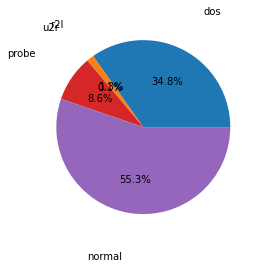

In [6]:
# Plot the ratio of each attack class with pie chart
labels = ['dos', 'r2l', 'u2r', 'probe', 'normal']
ratios = [len(df_dos)/len(df_kdd_data), len(df_r2l)/len(df_kdd_data), len(df_u2r)/len(df_kdd_data), len(df_probe)/len(df_kdd_data), len(df_normal)/len(df_kdd_data)]
plt.pie(ratios, labels=labels, autopct='%1.1f%%', labeldistance=1.5)
plt.show()


In [7]:
# Create labels
df_kdd_data_labels = df_kdd_data['attack_category']
df_kdd_data_coloured_labels = ['purple'] * len(df_kdd_data_labels)
for i in range(len(df_kdd_data_labels)):
    if df_kdd_data_labels[i] == 'dos':
        df_kdd_data_coloured_labels[i] = 'blue'
    elif df_kdd_data_labels[i] == 'r2l':
        df_kdd_data_coloured_labels[i] = 'orange'
    elif df_kdd_data_labels[i] == 'u2r':
        df_kdd_data_coloured_labels[i] = 'green'
    elif df_kdd_data_labels[i] == 'probe':
        df_kdd_data_coloured_labels[i] = 'red'

df_kdd_data_without_labels = df_kdd_data.drop(columns=['attack_category', 'attack_type'])


# Question 1 - What elements are the most distinctive or useful to detect each attack?

In order to answer the question above and obtain the insights for each category, I am going to perform PCA on each category and see what are the distinctive features.

## PCA for the entire dataset

[1.64505292 0.72619022 0.46518548]
[0.38888264 0.17166789 0.10996762]


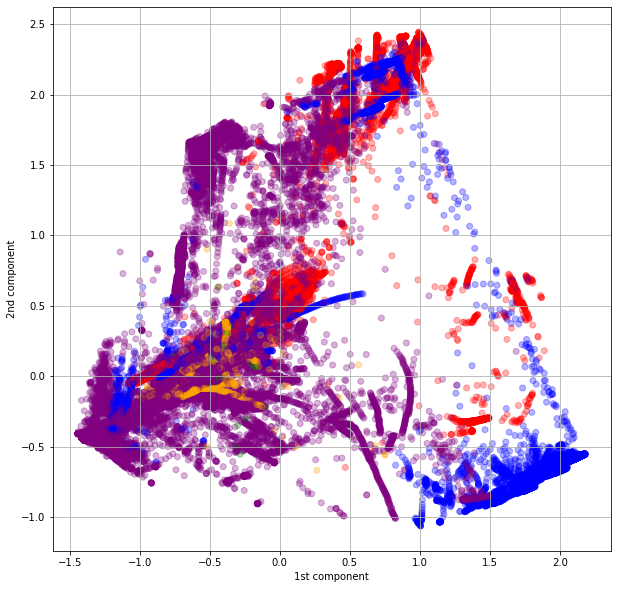

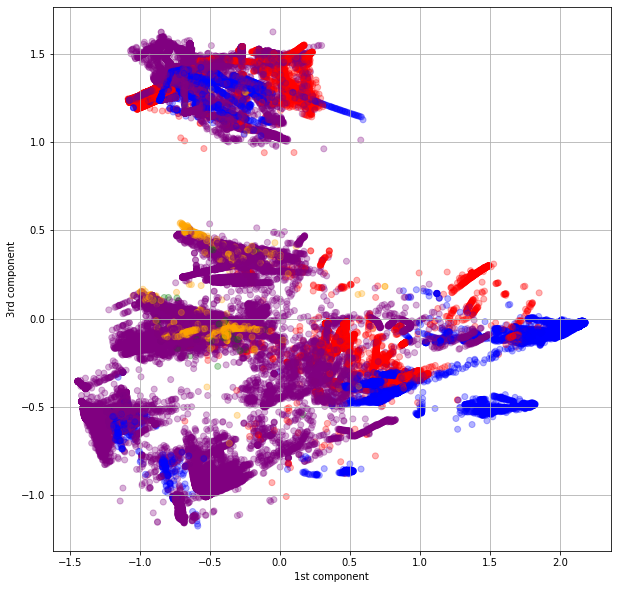

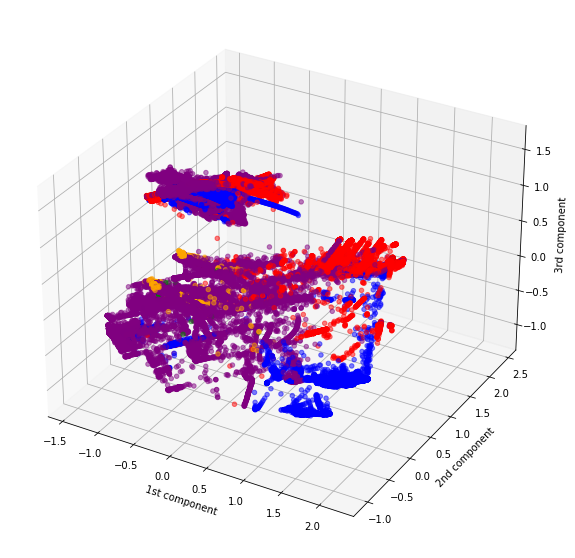

In [8]:
# Perform min-max normalisation on dataframe.
df_kdd_data_std = (df_kdd_data_without_labels-df_kdd_data_without_labels.min())/(df_kdd_data_without_labels.max()-df_kdd_data_without_labels.min())
df_kdd_data_std = pd.DataFrame(df_kdd_data_std.replace(np.nan, 0))

pca = PCA(n_components=3)
pca.fit(df_kdd_data_std)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
# print(pca.components_)

X_pca = pca.transform(df_kdd_data_std)

f, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, c=df_kdd_data_coloured_labels)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f2, ax2 = plt.subplots(figsize=(10,10))
ax2.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.3, c=df_kdd_data_coloured_labels)
ax2.set_xlabel('1st component')
ax2.set_ylabel('3rd component')
ax2.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.5, c=df_kdd_data_coloured_labels)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')

loadings = pd.DataFrame(pca.components_, columns=df_kdd_data_std.columns)
loadings = abs(loadings.T)

first_components_contributors = loadings.sort_values(by = 0, ascending=False).head(10)
second_components_contributors = loadings.sort_values(by = 1, ascending=False).head(10)
third_components_contributors = loadings.sort_values(by = 2, ascending=False).head(10)



### 1st Component

In [9]:
print(first_components_contributors)

                                 0         1         2
SF                        0.338484  0.152655  0.182077
same_srv_rate             0.304050  0.076733  0.059432
srv_serror_rate           0.296987  0.220217  0.048734
serror_rate               0.296984  0.217303  0.048775
dst_host_same_srv_rate    0.296898  0.138544  0.028655
dst_host_srv_serror_rate  0.296417  0.216961  0.041779
S0                        0.295652  0.217664  0.045935
dst_host_serror_rate      0.295082  0.214322  0.041325
dst_host_srv_count        0.267208  0.143590  0.090890
logged_in                 0.266288  0.181091  0.379281


### 2nd Component

In [10]:
print(second_components_contributors)

                                 0         1         2
srv_rerror_rate           0.039828  0.371023  0.131918
rerror_rate               0.040323  0.367614  0.130463
dst_host_srv_rerror_rate  0.040058  0.362974  0.126020
dst_host_rerror_rate      0.036496  0.341496  0.105447
REJ                       0.032981  0.289853  0.107088
srv_serror_rate           0.296987  0.220217  0.048734
S0                        0.295652  0.217664  0.045935
serror_rate               0.296984  0.217303  0.048775
dst_host_srv_serror_rate  0.296417  0.216961  0.041779
dst_host_serror_rate      0.295082  0.214322  0.041325


### 3rd Component

In [11]:
print(third_components_contributors)

                                    0         1         2
tcp                          0.068392  0.028879  0.521862
http                         0.217378  0.133662  0.410248
logged_in                    0.266288  0.181091  0.379281
udp                          0.041204  0.021591  0.350285
dst_host_same_src_port_rate  0.048886  0.054929  0.228403
domain_u                     0.031582  0.000750  0.198422
SF                           0.338484  0.152655  0.182077
icmp                         0.027188  0.007288  0.171577
srv_rerror_rate              0.039828  0.371023  0.131918
rerror_rate                  0.040323  0.367614  0.130463


## PCA for DoS

In [12]:
df_dos_without_labels = df_dos.drop(columns=['attack_category', 'attack_type'])

# Perform min-max normalisation on dataframe.
df_dos_std = (df_dos_without_labels-df_dos_without_labels.min())/(df_dos_without_labels.max()-df_dos_without_labels.min())
df_dos_std = pd.DataFrame(df_dos_std.replace(np.nan, 0))

pca_dos = PCA(n_components=10)
pca_dos.fit(df_dos_std)

print(pca_dos.explained_variance_)
print(pca_dos.explained_variance_ratio_)
# print(pca_dos.components_)

X_pca_dos = pca_dos.transform(df_dos_std)

loadings_dos = pd.DataFrame(pca_dos.components_, columns=df_dos_std.columns)
loadings_dos = abs(loadings_dos.T)

first_components_contributors_dos = loadings_dos.sort_values(by=0, ascending=False).head(10)
second_components_contributors_dos = loadings_dos.sort_values(by=1, ascending=False).head(10)
third_components_contributors_dos = loadings_dos.sort_values(by=2, ascending=False).head(10)


[1.62002362 0.65884903 0.23118495 0.17934081 0.06121887 0.04979417
 0.04238226 0.02705184 0.02550358 0.02432341]
[0.47017444 0.19121572 0.06709609 0.05204953 0.01776736 0.01445161
 0.01230047 0.00785117 0.00740183 0.00705931]


To determine the best numberr of clustering, I am going to measure inertia values and plot them in line graph.

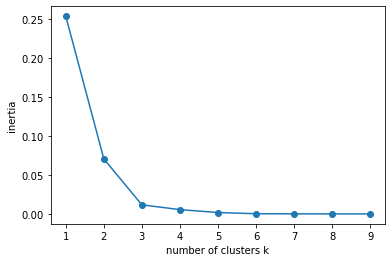

In [13]:
ks = range(1, 10)
inertias = []

for n in ks:
    model = KMeans(n_clusters=n)
    model.fit(pca_dos.components_[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The line graph above shows that after elbow point (3 clusters), the change in the value of inertia is no longer significant.
So, I'm going to reflect this clustering to PCA plot too.

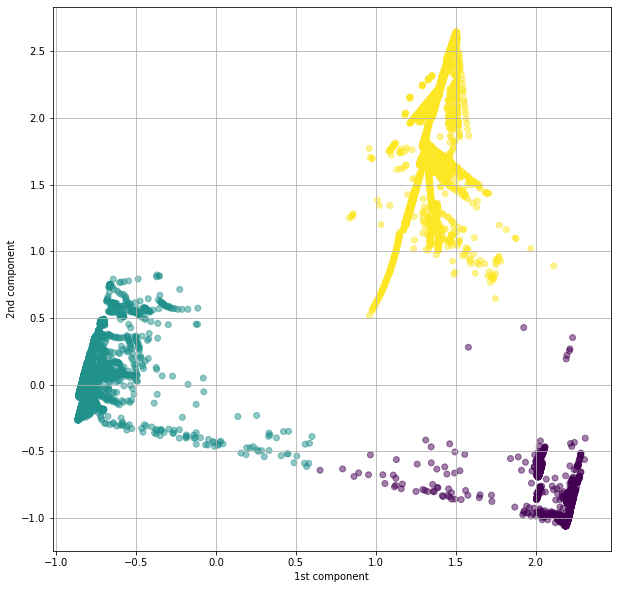

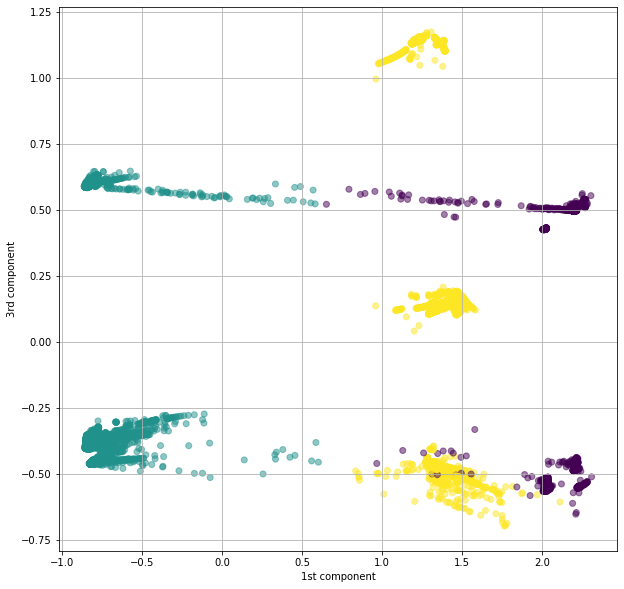

Text(0.5, 0, '3rd component')

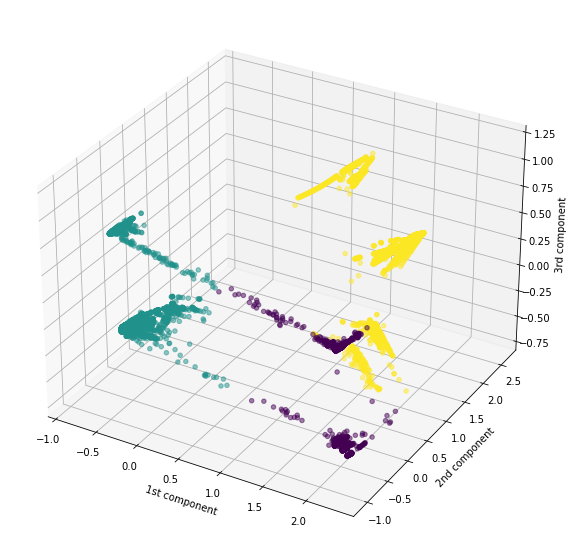

In [14]:
# Perform k-means
kmeans = KMeans(n_clusters=3)
pred = kmeans.fit_predict(df_dos_std)

f, ax = plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_dos[:, 0], X_pca_dos[:, 1], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f, ax= plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_dos[:, 0], X_pca_dos[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca_dos[:, 0], X_pca_dos[:, 1], X_pca_dos[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')


### 1st Component

In [25]:
print(first_components_contributors_dos[0])

S0                          0.356501
srv_serror_rate             0.355873
dst_host_srv_serror_rate    0.355314
serror_rate                 0.354853
dst_host_serror_rate        0.354171
dst_host_rerror_rate        0.265847
srv_rerror_rate             0.263100
rerror_rate                 0.262030
dst_host_srv_rerror_rate    0.261431
REJ                         0.221756
Name: 0, dtype: float64


- S0: one of `flag` values meaning connection attempt seen but no reply
- srv_serror_rate: % of connections that have `SYN` errors in `srv_count` that is number of connections to the same service as the current connection in the past 2 seconds
- dst_host_srv_serror_rate: % of connections that have `SYN` errors in `dst_host_count` that is number of connections that have the same destination host IP address
- serror_rate: % of connections that have `SYN` errors in `count` that is number of connections to the same host as the current connection in the past 2 seconds
- dst_host_serror_rate: % of connections that have `SYN` errors in `dst_host_count`

As you can see, it seems that many elements related to network error, especially server side error are listed on top.
From these top elements, I interpreted the 1st component as `Impact of error occuring mainly at server side`.



### 2nd Component

In [31]:
print(second_components_contributors_dos[1])

SF                          0.340343
same_srv_rate               0.330366
tcp                         0.282334
dst_host_srv_rerror_rate    0.254657
rerror_rate                 0.253307
srv_rerror_rate             0.251129
dst_host_same_srv_rate      0.249676
icmp                        0.248313
ecr_i                       0.247867
dst_host_rerror_rate        0.241498
Name: 1, dtype: float64


- SF: one of `flag` values meaning normal establishment and termination and there will be byte counts in the summary
- same_srv_rate: % of connections to the same service
- tcp: one of `protocol_type` values
- dst_host_srv_rerror_rate: % of connections that have `SYN` errors in `dst_host_count` that is number of connections that have the same destination host IP address
- rerror_rate: % of connections that have `REJ` errors in `count` that is number of connections to the same host as the current connection in the past 2 seconds

As you can see, 
From these top elements, there are some elements that involve requests to "same host or server" and errors. I interpreted the 2nd primary component as `Stickiness of requests to the same host involving error`.


### 3rd Component

In [32]:
print(third_components_contributors_dos[2])

private                     0.942499
tcp                         0.131086
http                        0.107597
wrong_fragment              0.086004
udp                         0.085633
SF                          0.084403
RSTO                        0.062321
srv_rerror_rate             0.060694
rerror_rate                 0.059133
dst_host_srv_rerror_rate    0.055806
Name: 2, dtype: float64


- private: one of `service` values
- tcp: one of `protocol_type` values
- http: one of `service` values
- wrong_fragment: number of `wrong` fragments
- udp: one of `protocol_type` value

As you can see, element `private` in `service` contributes a lot to the 3rd component, followed by `tcp` and `http`.
From these top elements, I interpreted the 3rd component as ``.


## PCA for R2L

In [33]:
df_r2l_without_labels = df_r2l.drop(columns=['attack_category', 'attack_type'])

# Perform min-max normalisation on dataframe.
df_r2l_std = (df_r2l_without_labels-df_r2l_without_labels.min())/(df_r2l_without_labels.max()-df_r2l_without_labels.min())
df_r2l_std = pd.DataFrame(df_r2l_std.replace(np.nan, 0))

pca_r2l = PCA(n_components=10)
pca_r2l.fit(df_r2l_std)

print(pca_r2l.explained_variance_)
print(pca_r2l.explained_variance_ratio_)
# print(pca_r2l.components_)

X_pca_r2l = pca_r2l.transform(df_r2l_std)

loadings_r2l = pd.DataFrame(pca_r2l.components_, columns=df_r2l_std.columns)
loadings_r2l = abs(loadings_r2l.T)

first_components_contributors_r2l = loadings_r2l.sort_values(by = 0, ascending=False).head(10)
second_components_contributors_r2l = loadings_r2l.sort_values(by = 1, ascending=False).head(10)
third_components_contributors_r2l = loadings_r2l.sort_values(by = 2, ascending=False).head(10)


[1.28805162 0.16151369 0.10205131 0.07782876 0.04802532 0.03471277
 0.03021053 0.0292837  0.02136594 0.01906738]
[0.66910008 0.083901   0.05301227 0.04042946 0.02494756 0.01803213
 0.01569337 0.01521191 0.0110989  0.00990487]


To determine the best numberr of clustering, I am going to measure inertia values and plot them in line graph.

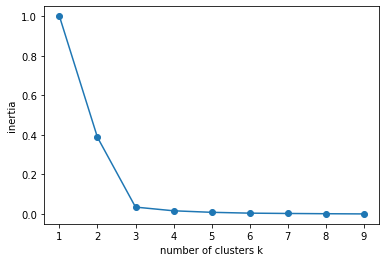

In [34]:
ks = range(1, 10)
inertias = []

for n in ks:
    model = KMeans(n_clusters=n)
    model.fit(pca_r2l.components_[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The line graph above shows that after elbow point (3 clusters), the change in the value of inertia is no longer significant. So, I'm going to reflect this clustering to PCA plot too.

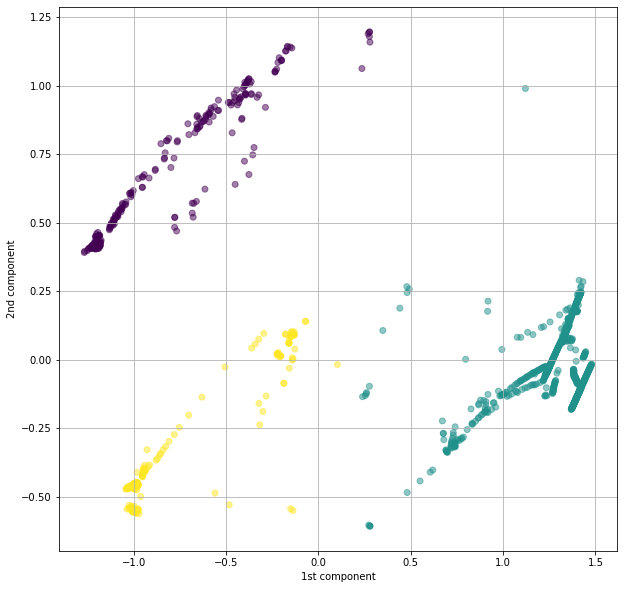

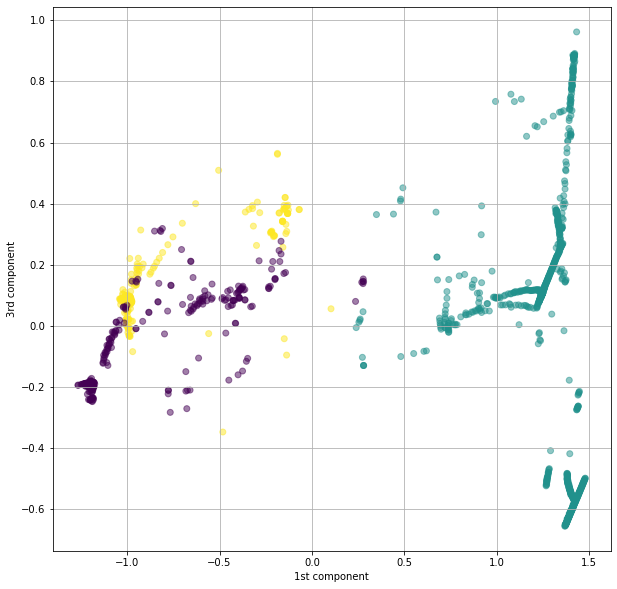

Text(0.5, 0, '3rd component')

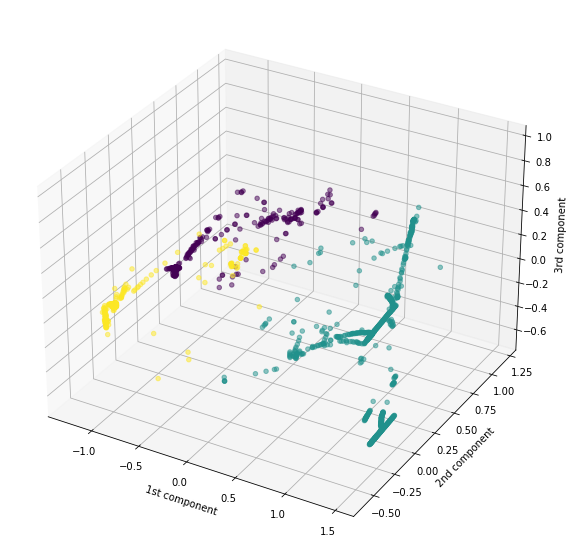

In [35]:
# Perform k-means
kmeans = KMeans(n_clusters=3)
pred = kmeans.fit_predict(df_r2l_std)

f, ax = plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_r2l[:, 0], X_pca_r2l[:, 1], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f, ax= plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_r2l[:, 0], X_pca_r2l[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca_r2l[:, 0], X_pca_r2l[:, 1], X_pca_r2l[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')


### 1st Component

In [36]:
print(first_components_contributors_r2l[0])

is_guest_login                 0.423035
ftp                            0.422496
ftp_data                       0.420523
dst_host_same_src_port_rate    0.399979
dst_host_count                 0.364272
dst_host_same_srv_rate         0.294040
logged_in                      0.202271
hot                            0.178069
dst_host_srv_diff_host_rate    0.063847
dst_host_rerror_rate           0.061717
Name: 0, dtype: float64


- is_guest_login: binary value whether user is guest login or not
- ftp: one of `protocol_type` values
- ftp_data: one of 'service' values
- dst_host_same_src_port_rate: % of connections that have the same source port in `dst_host_srv_count` that is Number of connections that have the same destination port number
- dst_host_count: number of connections that have the same destination host IP address

As you can see, there are some ftp related elements. Probably that is because R2L category can be an initial access to get into systems and involve in sending shellscripts to make it smoothly. Of course, attackers don't log in when actively browsing breaking points not to leave their tracks.
From these observations, I interepreted the 1st primary component as `Activeness of searching for breaking points`.


### 2nd Component

In [37]:
print(second_components_contributors_r2l[1])

logged_in                      0.878088
dst_host_same_srv_rate         0.303000
dst_host_same_src_port_rate    0.244066
dst_host_count                 0.165714
dst_host_diff_srv_rate         0.109703
hot                            0.092738
src_bytes                      0.071087
ftp                            0.067665
dst_host_srv_count             0.067523
dst_host_rerror_rate           0.064243
Name: 1, dtype: float64


- logged_in: binary value whether user is logged in or not
- dst_host_same_srv_rate: % of connections that have the same destination service in `dst_host_count` that is number of connections that have the same destination host IP address
- dst_host_same_src_port_rate: % of connections that have the same source port in `dst_host_srv_count` that is Number of connections that have the same destination port number
- dst_host_count: number of connections that have the same destination host IP address
- dst_host_diff_srv_rate: % of connections that have the different destination service in `dst_host_count` that is number of connections that have the same destination host IP address

As you can see, `logged_in` is dominating the ratio in the second primary component. After the first compromisation, attackers would try to obtain higher privileges with lateral movements or by exploring other weak softwares.
From these top elements, I interepreted the 2nd primary component as `Lateral movement`.


### 3rd Component

In [38]:
print(third_components_contributors_r2l[2])

hot                            0.750052
dst_host_rerror_rate           0.372258
dst_host_diff_srv_rate         0.359328
logged_in                      0.279946
dst_host_same_srv_rate         0.225469
dst_host_srv_count             0.121698
dst_host_count                 0.069765
ftp                            0.064278
is_guest_login                 0.060865
dst_host_same_src_port_rate    0.058833
Name: 2, dtype: float64


- hot: number of `hot` indicators
- dst_host_rerror_rate: % of connections that have `SYN` errors in `dst_host_count` that is number of connections that have the same destination host IP address
- dst_host_diff_srv_rate: % of connections that have the different destination service in `dst_host_count` that is number of connections that have the same destination host IP address
- logged_in: binary value whether user is logged in or not
- dst_host_same_srv_rate: % of connections that have the same destination service in `dst_host_count` that is number of connections that have the same destination host IP address

As you can see,
From these top elements, I interepreted the 3rd primary component as ''.


## PCA for U2R

In [39]:
df_u2r_without_labels = df_u2r.drop(columns=['attack_category', 'attack_type'])
list_u2r_color = ['green'] * len(df_u2r)

# Perform min-max normalisation on dataframe.
df_u2r_std = (df_u2r_without_labels-df_u2r_without_labels.min())/(df_u2r_without_labels.max()-df_u2r_without_labels.min())
df_u2r_std = pd.DataFrame(df_u2r_std.replace(np.nan, 0))

pca_u2r = PCA(n_components=10)
pca_u2r.fit(df_u2r_std)

print(pca_u2r.explained_variance_)
print(pca_u2r.explained_variance_ratio_)
# print(pca_u2r.components_)

X_pca_u2r = pca_u2r.transform(df_u2r_std)

loadings_u2r = pd.DataFrame(pca_u2r.components_, columns=df_u2r_std.columns)
loadings_u2r = abs(loadings_u2r.T)

first_components_contributors_u2r = loadings_u2r.sort_values(by = 0, ascending=False).head(10)
second_components_contributors_u2r = loadings_u2r.sort_values(by = 1, ascending=False).head(10)
third_components_contributors_u2r = loadings_u2r.sort_values(by = 2, ascending=False).head(10)


[0.70453952 0.44925614 0.18575874 0.15617687 0.13101228 0.09799465
 0.07926958 0.07081717 0.0574443  0.04898618]
[0.30075652 0.19178017 0.0792974  0.06666938 0.05592702 0.04183233
 0.0338389  0.0302307  0.02452204 0.02091141]


To determine the best numberr of clustering, I am going to measure inertia values and plot them in line graph.

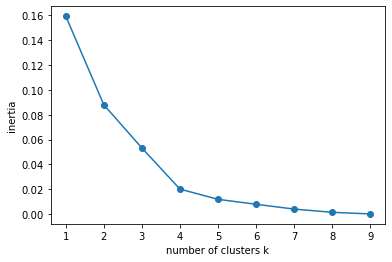

In [40]:
ks = range(1, 10)
inertias = []

for n in ks:
    model = KMeans(n_clusters=n)
    model.fit(pca_u2r.components_[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The line graph above shows that after elbow point (4 clusters), the change in the value of inertia is no longer significant. So, I'm going to reflect this clustering to PCA plot too.

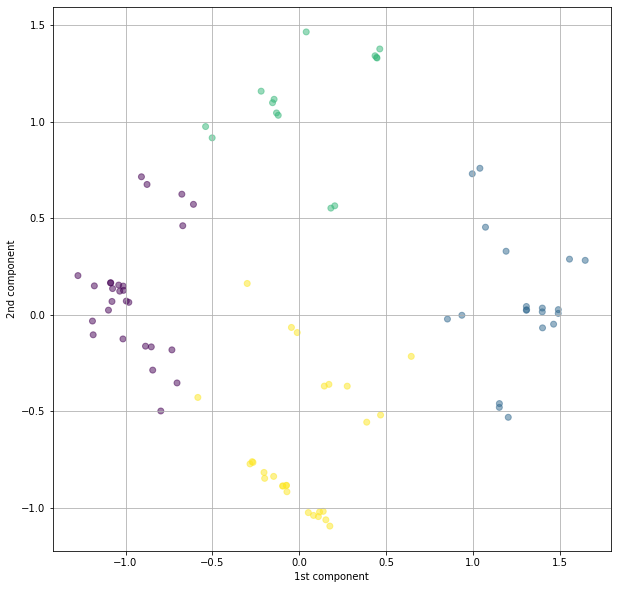

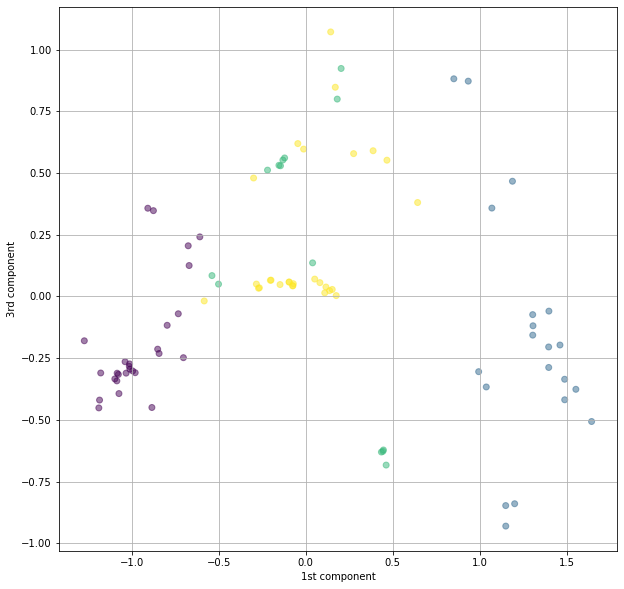

Text(0.5, 0, '3rd component')

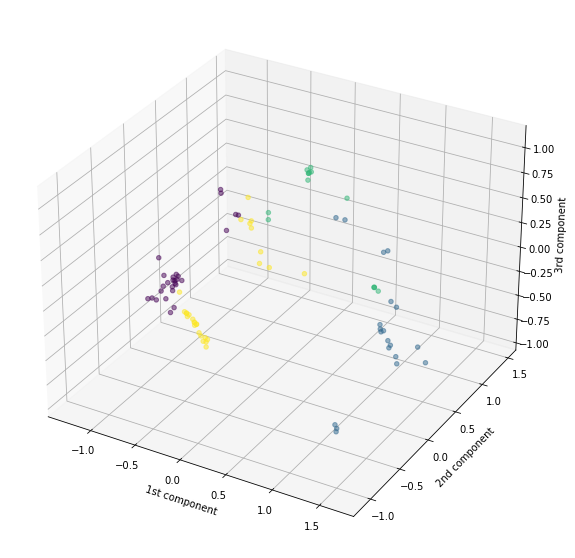

In [41]:
# Perform k-means
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit_predict(df_u2r_std)

f, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
ax.scatter(X_pca_u2r[:, 0], X_pca_u2r[:, 1], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f, ax= plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_u2r[:, 0], X_pca_u2r[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca_u2r[:, 0], X_pca_u2r[:, 1], X_pca_u2r[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')


### 1st Component

In [42]:
print(first_components_contributors_u2r[0])

telnet                         0.431697
dst_host_same_src_port_rate    0.420494
ftp_data                       0.372099
dst_host_count                 0.365906
dst_host_same_srv_rate         0.361614
root_shell                     0.325922
srv_count                      0.186518
logged_in                      0.143834
hot                            0.119532
dst_host_rerror_rate           0.106026
Name: 0, dtype: float64


- telnet: one of `service` values
- dst_host_same_src_port_rate: % of connections that have the same source port in `dst_host_srv_count` that is Number of connections that have the same destination port number
- ftp_data: one of `service` values
- dst_host_count: number of connections that have the same destination host IP address
- dst_host_same_srv_rate: % of connections that have the same destination service in `dst_host_count` that is number of connections that have the same destination host IP address

As you can see, there are some elements involving requests to same host or ports. U2R is the category in which attackers try to obtain local root privileges.
From these top elements, I interepreted the 1st primary component as `action of gaining root privileges`.


### 2nd Component

In [43]:
print(second_components_contributors_u2r[1])

root_shell                     0.476091
dst_host_count                 0.435504
dst_host_same_srv_rate         0.434522
telnet                         0.374512
logged_in                      0.287385
dst_host_same_src_port_rate    0.265361
ftp                            0.165461
ftp_data                       0.152211
hot                            0.131360
dst_host_diff_srv_rate         0.063768
Name: 1, dtype: float64


- root_shell: binary value whether root shell is obtained or not
- dst_host_count: number of connections that have the same destination host IP address
- dst_host_same_srv_rate: % of connections that have the same destination service in `dst_host_count` that is number of connections that have the same destination host IP address
- telnet: one of `service` values
- logged_in: binary value whether root shell is obtained or not

As you can see, the contribution value to the 2nd primary component of `root_shell` is risen from the first one.
From these top elements, I interepreted the 2nd primary component as `Credential access with root privileges`.


### 3rd Component

In [44]:
print(third_components_contributors_u2r[2])

ftp_data                  0.525413
root_shell                0.506395
ftp                       0.376974
dst_host_count            0.266559
srv_count                 0.258937
dst_host_srv_count        0.168755
logged_in                 0.161686
serror_rate               0.117396
num_file_creations        0.116360
dst_host_same_srv_rate    0.110964
Name: 2, dtype: float64


- ftp_data: one of `service` values
- root_shell: binary value whether root shell is obtained or not
- ftp: one of `service` values
- dst_host_count: number of connections that have the same destination host IP address
- srv_count: number of connections to the same service as the current connection in the past 2 seconds

As you can see,
From these top elements, I interepreted the 3rd component as ''.


## PCA for Probe

In [45]:
df_probe_without_labels = df_probe.drop(columns=['attack_category', 'attack_type'])
list_probe_color = ['red'] * len(df_probe)

# Perform min-max normalisation on dataframe.
df_probe_std = (df_probe_without_labels-df_probe_without_labels.min())/(df_probe_without_labels.max()-df_probe_without_labels.min())
df_probe_std = pd.DataFrame(df_probe_std.replace(np.nan, 0))

pca_probe = PCA(n_components=10)
pca_probe.fit(df_probe_std)

print(pca_probe.explained_variance_)
print(pca_probe.explained_variance_ratio_)
# print(pca_probe.components_)

X_pca_probe = pca_probe.transform(df_probe_std)

loadings_probe = pd.DataFrame(pca_probe.components_, columns=df_probe_std.columns)
loadings_probe = abs(loadings_probe.T)

first_components_contributors_probe = loadings_probe.sort_values(by = 0, ascending=False).head(10)
second_components_contributors_probe = loadings_probe.sort_values(by = 1, ascending=False).head(10)
third_components_contributors_probe = loadings_probe.sort_values(by = 2, ascending=False).head(10)


[2.53183712 0.53255757 0.49609681 0.22981473 0.21455521 0.09971693
 0.07676396 0.06306048 0.0476731  0.04211897]
[0.54564743 0.11477384 0.10691602 0.04952839 0.04623974 0.02149044
 0.01654374 0.01359044 0.01027424 0.00907725]


To determine the best numberr of clustering, I am going to measure inertia values and plot them in line graph.

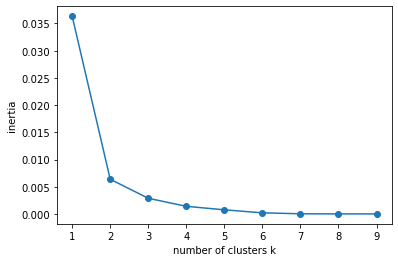

In [46]:
ks = range(1, 10)
inertias = []

for n in ks:
    model = KMeans(n_clusters=n)
    model.fit(pca_probe.components_[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The line graph above shows that after elbow point (3 clusters), the change in the value of inertia is no longer significant. So, I'm going to reflect this clustering to PCA plot too.

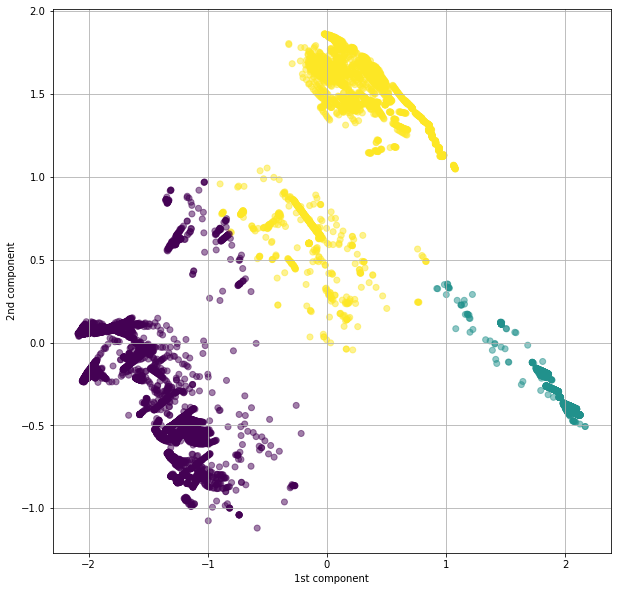

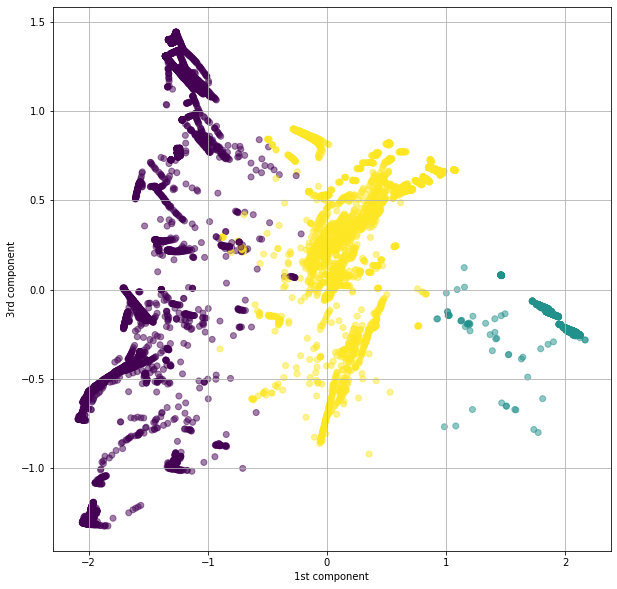

Text(0.5, 0, '3rd component')

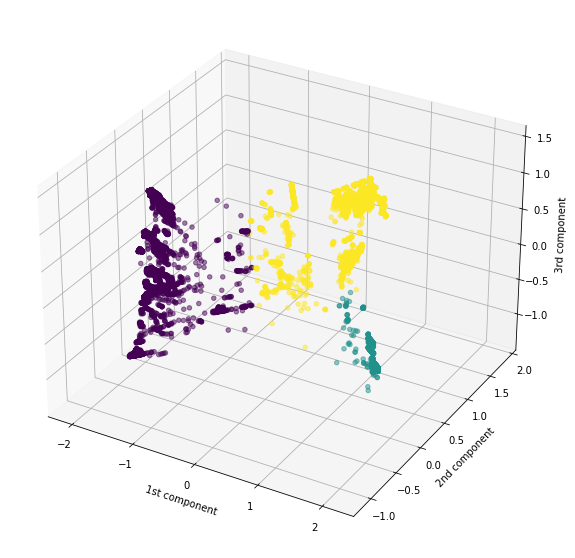

In [47]:
# Perform k-means
kmeans = KMeans(n_clusters=3)
pred = kmeans.fit_predict(df_probe_std)

f, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
ax.scatter(X_pca_probe[:, 0], X_pca_probe[:, 1], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f, ax= plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_probe[:, 0], X_pca_probe[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca_probe[:, 0], X_pca_probe[:, 1], X_pca_probe[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')


### 1st Component

In [48]:
print(first_components_contributors_probe[0])

tcp                         0.284479
SF                          0.283622
srv_rerror_rate             0.273519
dst_host_srv_rerror_rate    0.272608
dst_host_same_srv_rate      0.269814
rerror_rate                 0.264281
icmp                        0.264037
eco_i                       0.261994
dst_host_count              0.243266
srv_diff_host_rate          0.222808
Name: 0, dtype: float64


- tcp: one of `protocol_type` values
- SF: one of `flag` values meaning normal establishment and termination and there will be byte counts in the summary
- srv_rerror_rate: % of connections that have `REJ` errors in `srv_count` that is number of connections to the same service as the current connection in the past 2 seconds
- dst_host_srv_rerror_rate: % of connections that have `SYN` errors in `dst_host_count` that is number of connections that have the same destination host IP address
- dst_host_same_srv_rate: % of connections that have the same destination service in `dst_host_count` that is number of connections that have the same destination host IP address

As you can see, differences between top 5 or 10 elements are relatively small compared to other categories. Probe is the category in which attackers do reconnaissance and gather information of target systems
From these top elements, I interepreted the 1st primary component as `Cyber espionage`.


### 2nd Component

In [50]:
print(second_components_contributors_probe[1])

udp                         0.438016
srv_rerror_rate             0.284561
dst_host_srv_rerror_rate    0.280402
private                     0.268811
rerror_rate                 0.262347
same_srv_rate               0.251137
dst_host_count              0.239378
eco_i                       0.231078
icmp                        0.229820
SF                          0.220995
Name: 1, dtype: float64


- udp: one of `protocol_type` values
- srv_rerror_rate: % of connections that have `REJ` errors in `srv_count` that is number of connections to the same service as the current connection in the past 2 seconds
- dst_host_srv_rerror_rate: % of connections that have `SYN` errors in `dst_host_count` that is number of connections that have the same destination host IP address
- private: one of `service` values
- rerror_rate: % of connections that have “REJ” errors in `count` that is number of connections to the same host as the current connection in the past 2 seconds

Here, `UDP` contributes more to the 2nd primary component than other elements although TCP is more prevalent in general.
From these top elements, I interepreted the 2nd primary component as `wider range of cyberespionage`.


### 3rd Component


In [51]:
print(third_components_contributors_probe[2])

diff_srv_rate                  0.388356
RSTR                           0.381702
same_srv_rate                  0.363392
private                        0.357602
REJ                            0.347469
count                          0.303602
dst_host_same_src_port_rate    0.251074
other                          0.224018
eco_i                          0.143985
icmp                           0.143526
Name: 2, dtype: float64


- diff_srv_rate: % of connections to different service
- RSTR: connection reset by the responder
- same_srv_rate: % of connections to the same service
- private: one of `service` values
- REJ: connectin attempt rejected

As you can see,
From these top elements, I interepreted the 3rd component as ''.


## MCA for Probe with log processing

In [52]:
df_probe_log = np.log((df_probe_without_labels-df_probe_without_labels.min())/(df_probe_without_labels.max()-df_probe_without_labels.min()))
df_probe_log = pd.DataFrame(df_probe_std.replace(np.nan, 0))

pca_probe_log = PCA(n_components=10)
pca_probe_log.fit(df_probe_log)

print(pca_probe_log.explained_variance_)
print(pca_probe_log.explained_variance_ratio_)
# print(pca.components_)

X_pca_probe_log = pca_probe_log.transform(df_probe_std)

loadings_probe_log = pd.DataFrame(pca_probe_log.components_, columns=df_probe_log.columns)
loadings_probe_log = abs(loadings_probe_log.T)

first_components_contributors_probe_log = loadings_probe_log.sort_values(by = 0, ascending=False).head(10)
second_components_contributors_probe_log = loadings_probe_log.sort_values(by = 1, ascending=False).head(10)
third_components_contributors_probe_log = loadings_probe_log.sort_values(by = 2, ascending=False).head(10)


[2.53183712 0.53255757 0.49609681 0.22981473 0.21455521 0.09971693
 0.07676396 0.06306048 0.0476731  0.04211897]
[0.54564743 0.11477384 0.10691602 0.04952839 0.04623974 0.02149044
 0.01654374 0.01359044 0.01027424 0.00907725]


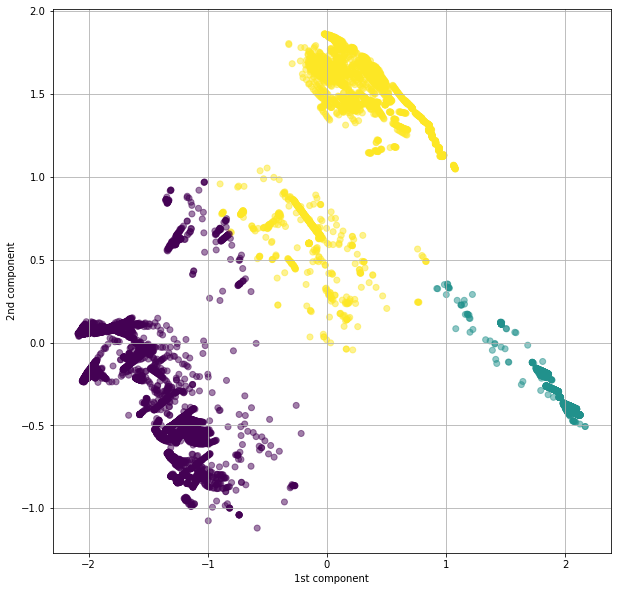

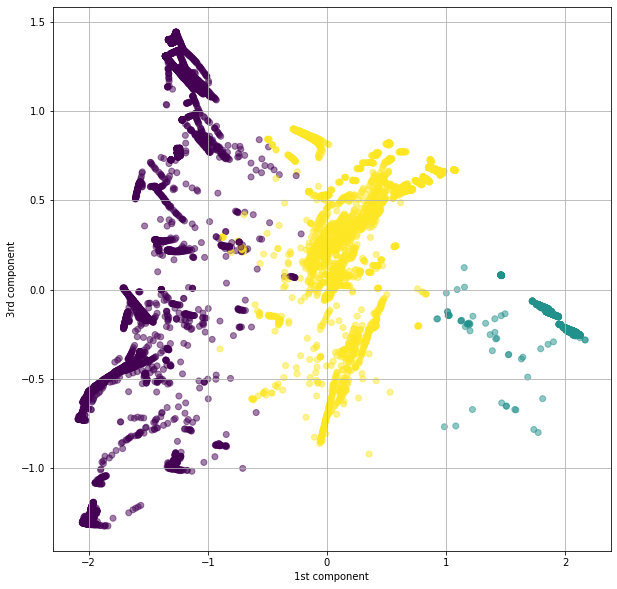

Text(0.5, 0, '3rd component')

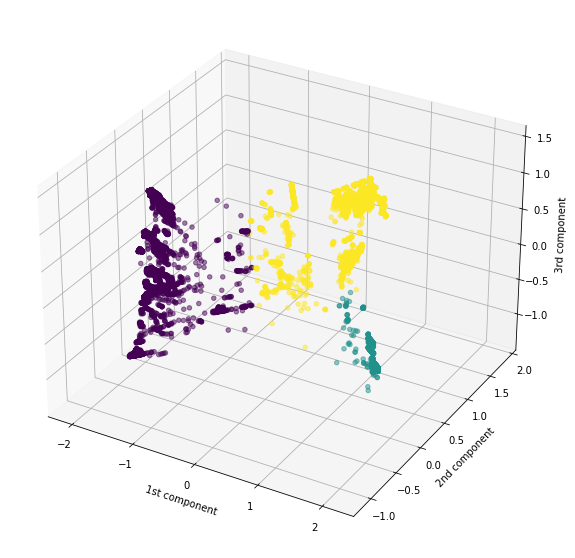

In [53]:
# Perform k-means
kmeans = KMeans(n_clusters=3)
pred = kmeans.fit_predict(df_probe_std)

f, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
ax.scatter(X_pca_probe_log[:, 0], X_pca_probe_log[:, 1], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f, ax= plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_probe_log[:, 0], X_pca_probe_log[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca_probe_log[:, 0], X_pca_probe_log[:, 1], X_pca_probe_log[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')


### 1st Component

In [54]:
print(first_components_contributors_probe_log[0])

tcp                         0.284479
SF                          0.283622
srv_rerror_rate             0.273519
dst_host_srv_rerror_rate    0.272608
dst_host_same_srv_rate      0.269814
rerror_rate                 0.264281
icmp                        0.264037
eco_i                       0.261994
dst_host_count              0.243266
srv_diff_host_rate          0.222808
Name: 0, dtype: float64


### 2nd Component

In [55]:
print(second_components_contributors_probe_log[1])

udp                         0.438016
srv_rerror_rate             0.284561
dst_host_srv_rerror_rate    0.280402
private                     0.268811
rerror_rate                 0.262347
same_srv_rate               0.251137
dst_host_count              0.239378
eco_i                       0.231078
icmp                        0.229820
SF                          0.220995
Name: 1, dtype: float64


### 3rd Component

In [56]:
print(third_components_contributors_probe_log[2])

diff_srv_rate                  0.388356
RSTR                           0.381702
same_srv_rate                  0.363392
private                        0.357602
REJ                            0.347469
count                          0.303602
dst_host_same_src_port_rate    0.251074
other                          0.224018
eco_i                          0.143985
icmp                           0.143526
Name: 2, dtype: float64


## PCA for Normal

In [57]:
df_normal_without_labels = df_normal.drop(columns=['attack_category', 'attack_type'])
list_normal_color = ['purple'] * len(df_normal)

# Perform min-max normalisation on dataframe.
df_normal_std = (df_normal_without_labels-df_normal_without_labels.min())/(df_normal_without_labels.max()-df_normal_without_labels.min())
df_normal_std = pd.DataFrame(df_normal_std.replace(np.nan, 0))

pca_normal = PCA(n_components=10)
pca_normal.fit(df_normal_std)

print(pca_normal.explained_variance_)
print(pca_normal.explained_variance_ratio_)
# print(pca_normal.components_)

X_pca_normal = pca_normal.transform(df_normal_std)

loadings_normal = pd.DataFrame(pca_normal.components_, columns=df_normal_std.columns)
loadings_normal = abs(loadings_normal.T)

first_components_contributors_normal = loadings_normal.sort_values(by = 0, ascending=False).head(10)
second_components_contributors_normal = loadings_normal.sort_values(by = 1, ascending=False).head(10)
third_components_contributors_normal = loadings_normal.sort_values(by = 2, ascending=False).head(10)


[0.70018202 0.34976639 0.29009661 0.14489843 0.12835774 0.07792257
 0.05723117 0.05638522 0.05331165 0.04503787]
[0.31301195 0.15636086 0.12968586 0.06477593 0.05738152 0.03483479
 0.02558483 0.02520666 0.02383264 0.0201339 ]


To determine the best numberr of clustering, I am going to measure inertia values and plot them in line graph.

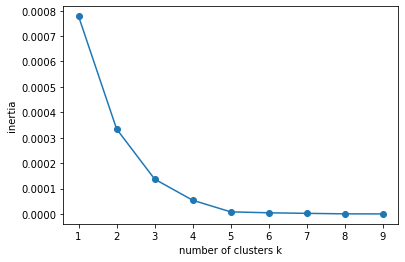

In [58]:
ks = range(1, 10)
inertias = []

for n in ks:
    model = KMeans(n_clusters=n)
    model.fit(pca_normal.components_[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The line graph above shows that after elbow point (4 clusters), the change in the value of inertia is no longer significant. So, I'm going to reflect this clustering to PCA plot too.

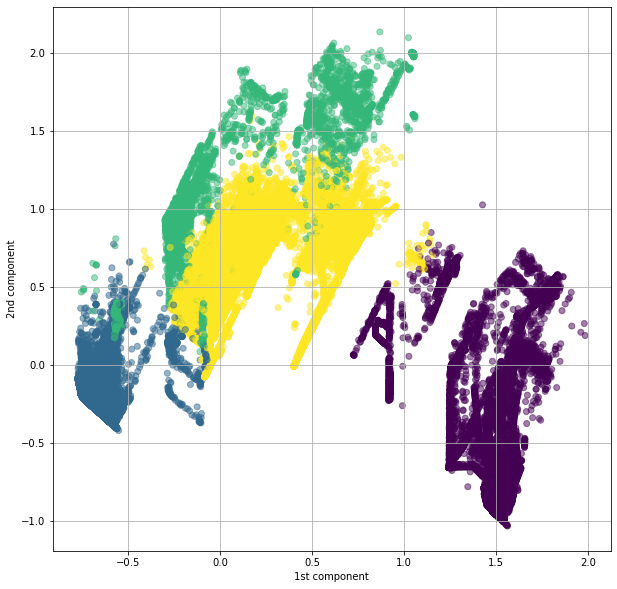

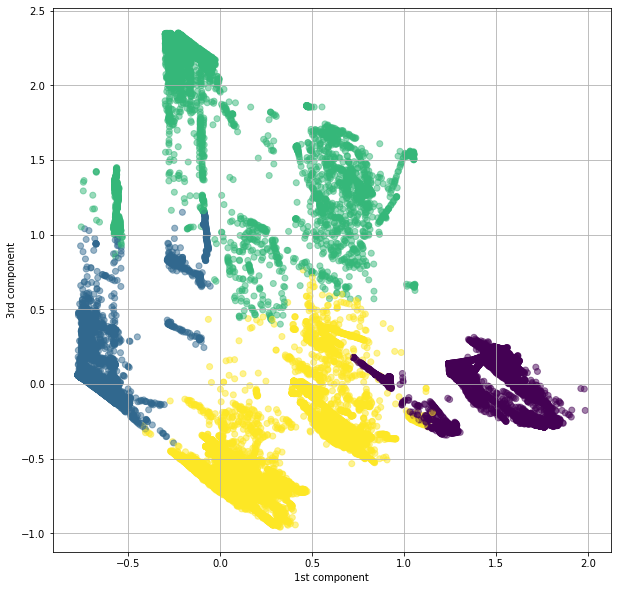

Text(0.5, 0, '3rd component')

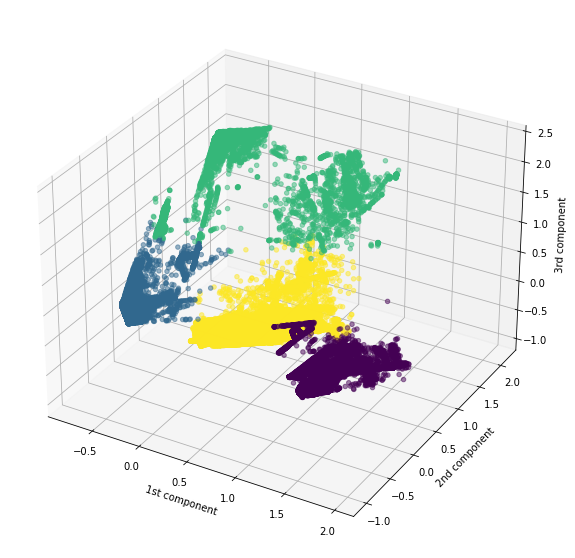

In [59]:
# Perform k-means
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit_predict(df_normal_std)

f, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
ax.scatter(X_pca_normal[:, 0], X_pca_normal[:, 1], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.grid()
plt.show()

f, ax= plt.subplots(ncols=1, figsize=(10,10))
ax.scatter(X_pca_normal[:, 0], X_pca_normal[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.grid()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_pca_normal[:, 0], X_pca_normal[:, 1], X_pca_normal[:, 2], alpha=0.5, c=pred)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')


### 1st Component

In [60]:
print(first_components_contributors_normal[0])

http                           0.495940
logged_in                      0.469197
tcp                            0.417369
udp                            0.388572
domain_u                       0.261757
dst_host_srv_count             0.192768
dst_host_count                 0.188042
dst_host_same_srv_rate         0.175011
dst_host_same_src_port_rate    0.085066
other                          0.075454
Name: 0, dtype: float64


- http: one of `service` values
- logged_in: binary value whether root shell is obtained or not
- tcp: one of `protocol_type` values
- udp: one of `protocol_type` values
- domain_u: one of `service` values

As you can see, we can observe more common protocol or elements. I think we can easily imagine that ordinary users net surf on their favorite web sites with logged in.
From these top elements, I interepreted the 1st primary component as `Normal web browsing behaviour`.


### 2nd Component

In [62]:
print(second_components_contributors_normal[1])

dst_host_srv_count        0.470132
dst_host_same_srv_rate    0.388995
udp                       0.281684
http                      0.281477
domain_u                  0.271087
tcp                       0.259458
SF                        0.206694
dst_host_count            0.193840
rerror_rate               0.174213
srv_rerror_rate           0.171089
Name: 1, dtype: float64


- dst_host_srv_count: number of connections that have the same destination port number
- dst_host_same_srv_rate: % of connections that have the same destination service in `dst_host_count` that is number of connections that have the same destination host IP address
- udp: one of `protocol_type` values
- http: one of `service` values
- domain_u: one of `service` values

As you can see,
From these top elements, I interepreted the 2nd component as ''.


### 3rd Component

In [63]:
print(third_components_contributors_normal[2])

SF                          0.380368
logged_in                   0.353430
rerror_rate                 0.341811
srv_rerror_rate             0.337977
dst_host_srv_rerror_rate    0.302208
http                        0.288195
REJ                         0.286228
dst_host_rerror_rate        0.280391
smtp                        0.212975
dst_host_same_srv_rate      0.199025
Name: 2, dtype: float64


- SF: one of `flag` values meaning normal establishment and termination and there will be byte counts in the summary
- logged_in: binary value whether root shell is obtained or not
- rerror_rate: % of connections that have “REJ” errors in `count` that is number of connections to the same host as the current connection in the past 2 seconds
- srv_rerror_rate: % of connections that have `REJ` errors in `srv_count` that is number of connections to the same service as the current connection in the past 2 seconds
- dst_host_srv_rerror_rate: % of connections that have `SYN` errors in `dst_host_count` that is number of connections that have the same destination host IP address

As you can see,
From these top elements, I interepreted the 3rd component as ''.


# Question 2 - How similar is each of attack class with normal requests?

In order to answer the question above and obtain the insights for each category, I am going to perform PCA on each category and see what are the distinctive features.

## Preparation
At first, I'm going to prepare new data frames with normal and each attack category.

In [64]:
df_normal_and_dos = pd.concat([df_normal, df_dos], ignore_index=True)
df_normal_and_dos_without_labels = df_normal_and_dos.drop(columns=['attack_category', 'attack_type'])
df_normal_and_dos_std = (df_normal_and_dos_without_labels-df_normal_and_dos_without_labels.min())/(df_normal_and_dos_without_labels.max()-df_normal_and_dos_without_labels.min())
df_normal_and_dos_std = pd.DataFrame(df_normal_and_dos_std.replace(np.nan, 0))
df_normal_and_dos_labels = df_normal_and_dos['attack_category']
df_normal_and_dos_coloured_labels = ['purple'] * len(df_normal_and_dos_labels)
for i in range(len(df_normal_and_dos_labels)):
    if df_normal_and_dos_labels[i] == 'dos':
        df_normal_and_dos_coloured_labels[i] = 'blue'

df_normal_and_r2l = pd.concat([df_normal, df_r2l], ignore_index=True)
df_normal_and_r2l_without_labels = df_normal_and_r2l.drop(columns=['attack_category', 'attack_type'])
df_normal_and_r2l_std = (df_normal_and_r2l_without_labels-df_normal_and_r2l_without_labels.min())/(df_normal_and_r2l_without_labels.max()-df_normal_and_r2l_without_labels.min())
df_normal_and_r2l_std = pd.DataFrame(df_normal_and_r2l_std.replace(np.nan, 0))
df_normal_and_r2l_labels = df_normal_and_r2l['attack_category']
df_normal_and_r2l_coloured_labels = ['purple'] * len(df_normal_and_r2l_labels)
for i in range(len(df_normal_and_r2l_labels)):
    if df_normal_and_r2l_labels[i] == 'r2l':
        df_normal_and_r2l_coloured_labels[i] = 'orange'

df_normal_and_u2r = pd.concat([df_normal, df_u2r], ignore_index=True)
df_normal_and_u2r_without_labels = df_normal_and_u2r.drop(columns=['attack_category', 'attack_type'])
df_normal_and_u2r_std = (df_normal_and_u2r_without_labels-df_normal_and_u2r_without_labels.min())/(df_normal_and_u2r_without_labels.max()-df_normal_and_u2r_without_labels.min())
df_normal_and_u2r_std = pd.DataFrame(df_normal_and_u2r_std.replace(np.nan, 0))
df_normal_and_u2r_labels = df_normal_and_u2r['attack_category']
df_normal_and_u2r_coloured_labels = ['purple'] * len(df_normal_and_u2r_labels)
for i in range(len(df_normal_and_u2r_labels)):
    if df_normal_and_u2r_labels[i] == 'u2r':
        df_normal_and_u2r_coloured_labels[i] = 'green'

df_normal_and_probe = pd.concat([df_normal, df_probe], ignore_index=True)
df_normal_and_probe_without_labels = df_normal_and_probe.drop(columns=['attack_category', 'attack_type'])
df_normal_and_probe_std = (df_normal_and_probe_without_labels-df_normal_and_probe_without_labels.min())/(df_normal_and_probe_without_labels.max()-df_normal_and_probe_without_labels.min())
df_normal_and_probe_std = pd.DataFrame(df_normal_and_probe_std.replace(np.nan, 0))
df_normal_and_probe_labels = df_normal_and_probe['attack_category']
df_normal_and_probe_coloured_labels = ['purple'] * len(df_normal_and_probe_labels)
for i in range(len(df_normal_and_probe_labels)):
    if df_normal_and_probe_labels[i] == 'probe':
        df_normal_and_probe_coloured_labels[i] = 'red'

# Remove `attack category` and `attack_type`
df_kdd_data_without_labels = df_kdd_data.drop(columns=['attack_category', 'attack_type'])


## MDA for Normal + DoS

In [ ]:
mds = MDS(n_components=2)
mds.fit(df_normal_and_dos_std)
XY_mds = mds.fit_transform(df_normal_and_dos_std)

kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(df_normal_and_dos_std)

f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,10))
ax1.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=df_normal_and_dos_coloured_labels)
ax2.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=pred)
ax1.grid()
ax2.grid()
plt.show()


## MDA for Normal + R2L

In [1]:
mds = MDS(n_components=2)
mds.fit(df_normal_and_r2l_std)
XY_mds = mds.fit_transform(df_normal_and_r2l_std)

kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(df_normal_and_r2l_std)

f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,10))
ax1.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=df_normal_and_r2l_coloured_labels)
ax2.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=pred)
ax1.grid()
ax2.grid()
plt.show()


NameError: name 'MDS' is not defined

## MDA for Normal + U2R

In [ ]:
mds = MDS(n_components=2)
mds.fit(df_normal_and_u2r_std)
XY_mds = mds.fit_transform(df_normal_and_u2r_std)

kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(df_normal_and_u2r_std)

f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,10))
ax1.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=df_normal_and_u2r_coloured_labels)
ax2.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=pred)
ax1.grid()
ax2.grid()
plt.show()


## MDA for Normal + Probe

In [ ]:
mds = MDS(n_components=2)
mds.fit(df_normal_and_probe_std)
XY_mds = mds.fit_transform(df_normal_and_probe_std)

kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(df_normal_and_probe_std)

f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,10))
ax1.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=df_normal_and_probe_coloured_labels)
ax2.scatter(XY_mds[:, 0], XY_mds[:, 1], alpha=0.5, c=pred)
ax1.grid()
ax2.grid()
plt.show()
